In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat May  7 19:07:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import os
import pickle
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from datetime import datetime
import logging

In [5]:
#logging 

# create run_lof folder if not exist
if not os.path.exists('/content/drive/MyDrive/DLCV_CW3/run_logs/'):
    os.mkdir('/content/drive/MyDrive/DLCV_CW3/run_logs/')


Log_Format = "%(levelname)s %(asctime)s - %(message)s"

logging.basicConfig(filename = "/content/drive/MyDrive/DLCV_CW3/run_logs/resnet_"+datetime.today().strftime("%d-%m-%Y-%H-%M-%S")+".log",
                    filemode = "w",
                    format = Log_Format, 
                    level = logging.ERROR)

logger = logging.getLogger()

# Load and normalize MNIST

In [6]:
logger.info("Loading MNIST dataset") 

mnist_data_dir = '/content/drive/MyDrive/DLCV_CW3/MNIST_data/'
mnist_save_dir = '/content/drive/MyDrive/DLCV_CW3/MNIST_RESNET_results/'
mnist_fig_dir = '/content/drive/MyDrive/DLCV_CW3/MNIST_RESNET_figures/'

# create folder if not exist
if not os.path.exists(mnist_save_dir):
    os.mkdir(mnist_save_dir)

if not os.path.exists(mnist_fig_dir):
    os.mkdir(mnist_fig_dir)

In [7]:
logger.info("Transforming MNIST dataset") 

mnist_transform = transforms.Compose([
    transforms.Resize(size=224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


mnist_train_data = datasets.MNIST(root=mnist_data_dir, train=True, transform=mnist_transform, download=True)

val_size = int(len(mnist_train_data) * 0.2)
train_size = len(mnist_train_data) - val_size

mnist_train_data, mnist_val_data = random_split(mnist_train_data, [train_size, val_size])
mnist_train_loader = DataLoader(dataset=mnist_train_data, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

mnist_val_loader = DataLoader(dataset=mnist_val_data, batch_size=64, shuffle=True, num_workers=4,pin_memory=True)

mnist_test_data = datasets.MNIST(root=mnist_data_dir, train=False, transform=mnist_transform, download=True)
mnist_test_loader = DataLoader(dataset=mnist_test_data, batch_size=64, shuffle=True, num_workers=4,pin_memory=True)

# Visualising the MNIST data 

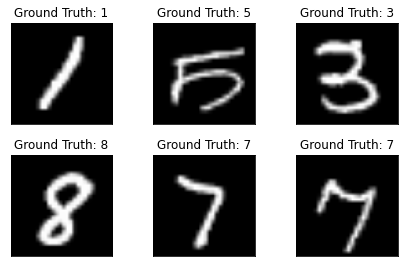

In [8]:
logger.info("Visualising MNIST dataset") 

examples = enumerate(mnist_train_loader)
batch_idx, (example_data, example_targets) = next(examples)

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])


# Load and normalize CIFAR10


In [9]:
logger.info("Loading Cifar dataset") 

cifar_data_dir = '/content/drive/MyDrive/DLCV_CW3/CIFAR10_data/'
cifar_save_dir = '/content/drive/MyDrive/DLCV_CW3/CIFAR10_RESNET_results/'
cifar_fig_dir = '/content/drive/MyDrive/DLCV_CW3/CIFAR10_RESNET_figures/'

# create folder if not exist
if not os.path.exists(cifar_save_dir):
    os.mkdir(cifar_save_dir)

if not os.path.exists(cifar_fig_dir):
    os.mkdir(cifar_fig_dir)

In [10]:
logger.info("Transforming CIFAR dataset") 

cifar_transform = transforms.Compose([
    transforms.Resize(size=224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


cifar_train_data = datasets.CIFAR10(root=cifar_data_dir, train=True, transform=cifar_transform, download=True)

val_size = int(len(cifar_train_data) * 0.2)
train_size = len(cifar_train_data) - val_size

cifar_train_data, cifar_val_data = random_split(cifar_train_data, [train_size, val_size])
cifar_train_loader = DataLoader(dataset = cifar_train_data, batch_size=64, shuffle=True, num_workers=4,pin_memory=True)

cifar_val_loader = DataLoader(dataset = cifar_val_data, batch_size=64, shuffle=True, num_workers=4,pin_memory=True)

cifar_test_data = datasets.CIFAR10(root=cifar_data_dir, train=False, transform=cifar_transform)
cifar_test_loader = DataLoader(dataset = cifar_test_data, batch_size=64, shuffle=False, num_workers=4,pin_memory=True)

cifar_classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified


# Visualising the CIFAR data 

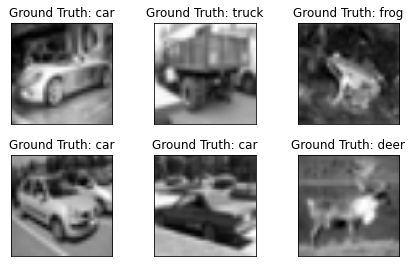

In [11]:
logger.info("Visualising CIFAR dataset") 

examples = enumerate(cifar_train_loader)
batch_idx, (example_data, example_targets) = next(examples)

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(cifar_classes[example_targets[i]]))
    plt.xticks([])
    plt.yticks([])


# Resnet50 Model Class

In [12]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)
        
        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
       
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x.clone()

        x = self.relu(self.batch_norm2(self.conv1(x)))
        x = self.batch_norm2(self.conv2(x))

        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        print(x.shape)
        print(identity.shape)
        x += identity
        x = self.relu(x)
        return x


        
        
class ResNet50(nn.Module):
    def __init__(self, num_channels=3, num_classes = 10, ResBlock = Bottleneck):
        super(ResNet50, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, 3, planes=64)
        self.layer2 = self._make_layer(ResBlock, 4, planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, 6, planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, 3, planes=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)


# Model Training Base Code 

In [13]:
def train_model(model, model_log_path, train_loader, val_loader, loss_function, optimizer):
    
    writer = SummaryWriter(model_log_path)

    
    epochs = 10

    if torch.cuda.is_available():
        device = torch.device('cuda')
        
    else:
        device = torch.device('cpu')
  
    model = model.to(device)


    # tracking variables
    train_hist = {}
    train_hist['model_train_losses'] = []
    train_hist['model_val_losses'] = []
    train_hist['model_val_accuracies'] = []
    train_hist['model_per_epoch_ptimes'] = []
    train_hist['model_total_ptime'] = []


    start_time = time.time()
    # training loop
    for epoch in range(epochs):
        model.train()
        loss_train = []    
        epoch_start_time = time.time()
        for (image, target) in tqdm(train_loader):
            image = image.to(device)

            target = target.to(device)

            ## Forward Pass
            model_optimizer.zero_grad()
            scores = model(image)
            loss = loss_function(scores,target.to(device))
            loss.backward()
            optimizer.step()
            loss_train.append(loss.item())

        val_accuracy = 0
        val_loss = []
        with torch.no_grad():
            num_correct = 0
            num_samples = 0
            for (image, target) in tqdm(val_loader):
                image = image.to(device)

                target = target.to(device)
                
                scores = model(image)
                loss = loss_function(scores,target.to(device)).item()
                _, predictions = scores.max(1)
                num_correct += (predictions == target.to(device)).sum()
                num_samples += predictions.size(0)
                val_loss.append(loss)
            val_accuracy = float(num_correct) / float(num_samples)

        epoch_loss_train = np.mean(loss_train)
        epoch_val_loss = np.mean(val_loss)
        epoch_val_accuracy = val_accuracy
        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time

        print("Epoch %d of %d with %.2f s" % (epoch + 1, epochs, per_epoch_ptime))
        print("Training loss: %.8f, Validation loss: %.8f, Validation Accuracies: %.8f " % (epoch_loss_train, epoch_val_loss, epoch_val_accuracy))

        # record the loss for every epoch
        train_hist['model_train_losses'].append(epoch_loss_train)
        train_hist['model_val_losses'].append(epoch_val_loss)
        train_hist['model_val_accuracies'].append(epoch_val_accuracy)
        train_hist['model_per_epoch_ptimes'].append(per_epoch_ptime)
        
        writer.add_scalar("Loss/train", epoch_loss_train, epoch)
        writer.add_scalar("Loss/Val", epoch_val_loss, epoch)
        writer.add_scalar("Accuracy/val", epoch_val_accuracy, epoch)


    end_time = time.time()
    total_ptime = end_time - start_time
    train_hist['model_total_ptime'].append(total_ptime)
    
    writer.flush()
    
    writer.close()

    print('Avg per epoch ptime: %.2f, total %d epochs ptime: %.2f' % (np.mean(train_hist['model_per_epoch_ptimes']), epochs, total_ptime))
    
    
    return model, train_hist

In [14]:
def test_model(model, test_loader, loss_function):
    
    num_correct = 0
    num_samples = 0

    if torch.cuda.is_available():
        device = torch.device('cuda')
        
    else:
        device = torch.device('cpu')
  

    test_loss = []

    for (image, target) in tqdm(test_loader):
        image = image.to(device)

        target = target.to(device)
        
        scores = model(image)

        loss = loss_function(scores,target).item()

        _, predictions = scores.max(1)
        num_correct += (predictions == target).sum()
        num_samples += predictions.size(0)

        test_loss.append(loss)

    test_accuracy = float(num_correct) / float(num_samples)
    avg_test_loss = np.mean(test_loss)

    print("Testing loss: %.8f, Testing Accuracies: %.8f " % (avg_test_loss, test_accuracy))

    return test_loss


# Training MNSIT dataset on RESNET50

Already trained on RESNET on mnist with lr=0.3 optimizer= Adam
Already trained on RESNET on mnist with lr=0.3 optimizer= SGD
Already trained on RESNET on mnist with lr=0.03 optimizer= Adam
Already trained on RESNET on mnist with lr=0.03 optimizer= SGD
Training RESNET on mnist with lr=0.003 optimizer= Adam


100%|██████████| 188/188 [00:22<00:00,  8.34it/s]


Epoch 1 of 10 with 272.54 s
Training loss: 0.45417427, Validation loss: 0.13207406, Validation Accuracies: 0.96266667 


100%|██████████| 188/188 [00:22<00:00,  8.33it/s]


Epoch 2 of 10 with 272.07 s
Training loss: 0.10504575, Validation loss: 0.09909231, Validation Accuracies: 0.97008333 


100%|██████████| 188/188 [00:22<00:00,  8.32it/s]


Epoch 3 of 10 with 272.14 s
Training loss: 0.07312176, Validation loss: 0.07637455, Validation Accuracies: 0.97833333 


100%|██████████| 188/188 [00:22<00:00,  8.36it/s]


Epoch 4 of 10 with 272.06 s
Training loss: 0.05879418, Validation loss: 0.08064409, Validation Accuracies: 0.97633333 


100%|██████████| 188/188 [00:22<00:00,  8.36it/s]


Epoch 5 of 10 with 271.65 s
Training loss: 0.05109282, Validation loss: 0.03556896, Validation Accuracies: 0.99016667 


100%|██████████| 188/188 [00:22<00:00,  8.34it/s]


Epoch 6 of 10 with 271.78 s
Training loss: 0.04550192, Validation loss: 0.04911069, Validation Accuracies: 0.98616667 


100%|██████████| 188/188 [00:22<00:00,  8.35it/s]


Epoch 7 of 10 with 271.80 s
Training loss: 0.03869992, Validation loss: 0.05215069, Validation Accuracies: 0.98450000 


100%|██████████| 188/188 [00:22<00:00,  8.33it/s]


Epoch 8 of 10 with 271.82 s
Training loss: 0.03572491, Validation loss: 0.03553462, Validation Accuracies: 0.98958333 


100%|██████████| 188/188 [00:22<00:00,  8.36it/s]


Epoch 9 of 10 with 271.72 s
Training loss: 0.03205815, Validation loss: 0.03591864, Validation Accuracies: 0.98958333 


100%|██████████| 188/188 [00:22<00:00,  8.35it/s]


Epoch 10 of 10 with 271.76 s
Training loss: 0.03071299, Validation loss: 0.03546839, Validation Accuracies: 0.99025000 
Avg per epoch ptime: 271.93, total 10 epochs ptime: 2719.34
Training finish!... save and plotting training results


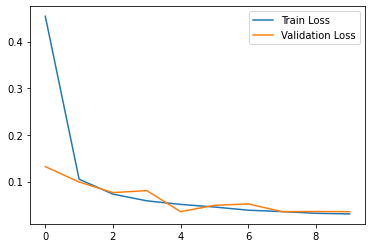

Testing RESNET trained model


100%|██████████| 157/157 [00:18<00:00,  8.30it/s]


Testing loss: 0.03577963, Testing Accuracies: 0.98880000 
Testing finish!... plotting testing results


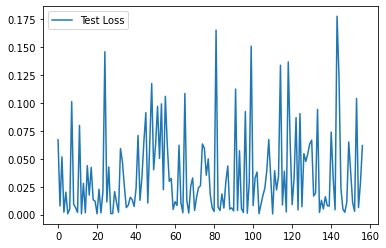

Training RESNET on mnist with lr=0.003 optimizer= SGD


100%|██████████| 188/188 [00:22<00:00,  8.34it/s]


Epoch 1 of 10 with 268.02 s
Training loss: 0.83083037, Validation loss: 0.19340241, Validation Accuracies: 0.95058333 


100%|██████████| 188/188 [00:22<00:00,  8.32it/s]


Epoch 2 of 10 with 268.08 s
Training loss: 0.12392857, Validation loss: 0.09863951, Validation Accuracies: 0.97400000 


100%|██████████| 188/188 [00:22<00:00,  8.31it/s]


Epoch 3 of 10 with 268.17 s
Training loss: 0.06659159, Validation loss: 0.06301085, Validation Accuracies: 0.98258333 


100%|██████████| 188/188 [00:22<00:00,  8.36it/s]


Epoch 4 of 10 with 267.92 s
Training loss: 0.04473587, Validation loss: 0.05362977, Validation Accuracies: 0.98466667 


100%|██████████| 188/188 [00:22<00:00,  8.36it/s]


Epoch 5 of 10 with 267.91 s
Training loss: 0.02894719, Validation loss: 0.04835842, Validation Accuracies: 0.98616667 


100%|██████████| 188/188 [00:22<00:00,  8.35it/s]


Epoch 6 of 10 with 268.01 s
Training loss: 0.01949943, Validation loss: 0.04171027, Validation Accuracies: 0.98766667 


100%|██████████| 188/188 [00:22<00:00,  8.35it/s]


Epoch 7 of 10 with 267.98 s
Training loss: 0.01362020, Validation loss: 0.04014934, Validation Accuracies: 0.98850000 


100%|██████████| 188/188 [00:22<00:00,  8.36it/s]


Epoch 8 of 10 with 267.93 s
Training loss: 0.00880773, Validation loss: 0.03744893, Validation Accuracies: 0.98891667 


100%|██████████| 188/188 [00:22<00:00,  8.36it/s]


Epoch 9 of 10 with 268.02 s
Training loss: 0.00606326, Validation loss: 0.03743487, Validation Accuracies: 0.98883333 


100%|██████████| 188/188 [00:22<00:00,  8.34it/s]


Epoch 10 of 10 with 268.10 s
Training loss: 0.00432336, Validation loss: 0.03969329, Validation Accuracies: 0.98866667 
Avg per epoch ptime: 268.01, total 10 epochs ptime: 2680.16
Training finish!... save and plotting training results


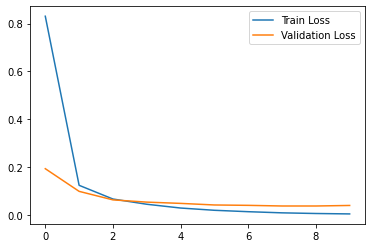

Testing RESNET trained model


100%|██████████| 157/157 [00:18<00:00,  8.27it/s]


Testing loss: 0.03765323, Testing Accuracies: 0.98830000 
Testing finish!... plotting testing results


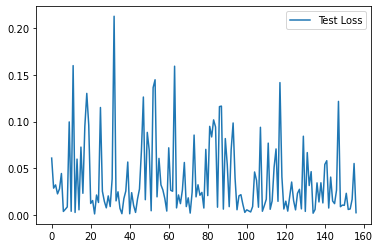

Training RESNET on mnist with lr=0.0003 optimizer= Adam


100%|██████████| 188/188 [00:22<00:00,  8.36it/s]


Epoch 1 of 10 with 271.98 s
Training loss: 0.13844198, Validation loss: 0.07019888, Validation Accuracies: 0.97841667 


100%|██████████| 188/188 [00:22<00:00,  8.35it/s]


Epoch 2 of 10 with 271.94 s
Training loss: 0.05627631, Validation loss: 0.04603573, Validation Accuracies: 0.98650000 


100%|██████████| 188/188 [00:22<00:00,  8.33it/s]


Epoch 3 of 10 with 272.11 s
Training loss: 0.04573807, Validation loss: 0.04594719, Validation Accuracies: 0.98708333 


100%|██████████| 188/188 [00:22<00:00,  8.36it/s]


Epoch 4 of 10 with 272.01 s
Training loss: 0.03672056, Validation loss: 0.04429306, Validation Accuracies: 0.98825000 


100%|██████████| 188/188 [00:22<00:00,  8.31it/s]


Epoch 5 of 10 with 272.07 s
Training loss: 0.03398680, Validation loss: 0.04211713, Validation Accuracies: 0.98725000 


100%|██████████| 188/188 [00:22<00:00,  8.32it/s]


Epoch 6 of 10 with 272.15 s
Training loss: 0.02751529, Validation loss: 0.02869429, Validation Accuracies: 0.99191667 


100%|██████████| 188/188 [00:22<00:00,  8.33it/s]


Epoch 7 of 10 with 272.18 s
Training loss: 0.03071721, Validation loss: 0.03482218, Validation Accuracies: 0.98950000 


100%|██████████| 188/188 [00:22<00:00,  8.33it/s]


Epoch 8 of 10 with 272.07 s
Training loss: 0.02710173, Validation loss: 0.02914751, Validation Accuracies: 0.99150000 


100%|██████████| 188/188 [00:22<00:00,  8.35it/s]


Epoch 9 of 10 with 272.04 s
Training loss: 0.02455707, Validation loss: 0.02934654, Validation Accuracies: 0.99041667 


100%|██████████| 188/188 [00:22<00:00,  8.36it/s]


Epoch 10 of 10 with 272.12 s
Training loss: 0.02256799, Validation loss: 0.03287960, Validation Accuracies: 0.98983333 
Avg per epoch ptime: 272.07, total 10 epochs ptime: 2720.68
Training finish!... save and plotting training results


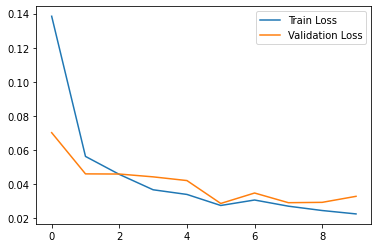

Testing RESNET trained model


100%|██████████| 157/157 [00:18<00:00,  8.29it/s]


Testing loss: 0.03086341, Testing Accuracies: 0.99090000 
Testing finish!... plotting testing results


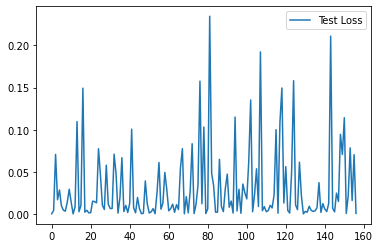

Training RESNET on mnist with lr=0.0003 optimizer= SGD


100%|██████████| 188/188 [00:22<00:00,  8.34it/s]


Epoch 1 of 10 with 268.29 s
Training loss: 1.98264955, Validation loss: 1.74291454, Validation Accuracies: 0.46741667 


100%|██████████| 188/188 [00:22<00:00,  8.34it/s]


Epoch 2 of 10 with 268.29 s
Training loss: 1.58309537, Validation loss: 1.41903800, Validation Accuracies: 0.61975000 


100%|██████████| 188/188 [00:22<00:00,  8.33it/s]


Epoch 3 of 10 with 268.29 s
Training loss: 1.23579742, Validation loss: 1.06285740, Validation Accuracies: 0.71766667 


100%|██████████| 188/188 [00:22<00:00,  8.32it/s]


Epoch 4 of 10 with 268.44 s
Training loss: 0.90399929, Validation loss: 0.76683393, Validation Accuracies: 0.80591667 


100%|██████████| 188/188 [00:22<00:00,  8.31it/s]


Epoch 5 of 10 with 268.55 s
Training loss: 0.63871264, Validation loss: 0.54030111, Validation Accuracies: 0.87650000 


100%|██████████| 188/188 [00:22<00:00,  8.34it/s]


Epoch 6 of 10 with 268.41 s
Training loss: 0.45156955, Validation loss: 0.39701073, Validation Accuracies: 0.91208333 


100%|██████████| 188/188 [00:22<00:00,  8.34it/s]


Epoch 7 of 10 with 268.41 s
Training loss: 0.33771985, Validation loss: 0.30681472, Validation Accuracies: 0.92966667 


100%|██████████| 188/188 [00:22<00:00,  8.31it/s]


Epoch 8 of 10 with 268.51 s
Training loss: 0.26218172, Validation loss: 0.24840555, Validation Accuracies: 0.94233333 


100%|██████████| 188/188 [00:22<00:00,  8.30it/s]


Epoch 9 of 10 with 268.50 s
Training loss: 0.21319142, Validation loss: 0.21001967, Validation Accuracies: 0.95008333 


100%|██████████| 188/188 [00:22<00:00,  8.34it/s]


Epoch 10 of 10 with 268.45 s
Training loss: 0.17910783, Validation loss: 0.17860991, Validation Accuracies: 0.95641667 
Avg per epoch ptime: 268.41, total 10 epochs ptime: 2684.16
Training finish!... save and plotting training results


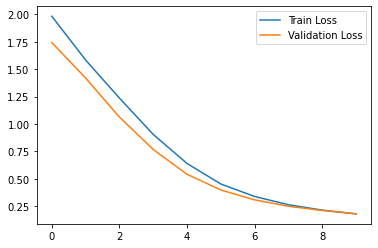

Testing RESNET trained model


100%|██████████| 157/157 [00:19<00:00,  8.26it/s]


Testing loss: 0.17113515, Testing Accuracies: 0.95940000 
Testing finish!... plotting testing results


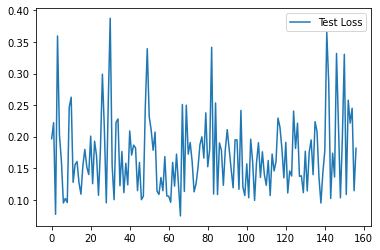

In [14]:
logger.info("Training resnet on MNIST dataset") 


for lr in [0.3, 0.03, 0.003, 0.0003]:
    for optimizer in ['Adam', 'SGD']:
        print("========================================================")
        #Cross Entropy Loss function
        criterion = nn.CrossEntropyLoss()

        if os.path.isfile(mnist_save_dir+"/resnet_mnist_lr-{}_opt-{}_".format(lr,optimizer)+".pt"):
            print("Already trained on RESNET on mnist with lr={} optimizer= {}".format(lr,optimizer))
  

        else:
            model = ResNet50(num_channels = 3, num_classes = 10)
            #model.eval()

            if optimizer == 'Adam':
                model_optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            if optimizer == 'SGD':
                model_optimizer = torch.optim.SGD(model.parameters(), lr=lr)

            print("Training RESNET on mnist with lr={} optimizer= {}".format(lr,optimizer))
          
            model_log_path = 'content/drive/MyDrive/DLCV_CW3/run_logs/mnist_resnet_train_lr-{}_opt-{}_'.format(lr,optimizer) +datetime.today().strftime("%d-%m-%Y-%H-%M-%S")

            trained_model, train_hist = train_model(model, model_log_path, mnist_train_loader, mnist_val_loader, criterion, model_optimizer)
            
            print("Training finish!... save and plotting training results")

            with open(mnist_save_dir +'train_hist_lr-{}_opt-{}_'.format(lr,optimizer)+datetime.today().strftime("%d-%m-%Y-%H-%M-%S")+'.pkl', 'wb') as f:
                pickle.dump(train_hist, f)

            logger.info("Saving RESNET trained model on  MNIST dataset") 
            torch.save(model.state_dict(), mnist_save_dir+"/resnet_mnist_lr-{}_opt-{}_".format(lr,optimizer)+".pt") 

            logger.info("Plotting RESNET Model train losses on MNIST") 

            plt.plot(train_hist['model_train_losses'])
            plt.plot(train_hist['model_val_losses'])
            plt.legend(["Train Loss", "Validation Loss"])
            plt.savefig(mnist_fig_dir + "/resnet_train_val_loss_lr-{}_opt-{}_".format(lr,optimizer)+".png") 
            plt.show()

            print("Testing RESNET trained model")
            test_loss = test_model(model, mnist_test_loader, criterion)
            print("Testing finish!... plotting testing results")
            plt.plot(test_loss)
            plt.legend(["Test Loss"])
            plt.savefig(mnist_fig_dir + "/resnet_test_val_loss_lr-{}_opt-{}_".format(lr,optimizer)+".png") 
            plt.show()
        print("========================================================")



# Training CIFAR 10 dataset on VGG

Training RESNET on cifar10 with lr=0.3 optimizer= Adam


100%|██████████| 157/157 [00:18<00:00,  8.30it/s]


Epoch 1 of 10 with 226.90 s
Training loss: 3.89488816, Validation loss: 2.11212780, Validation Accuracies: 0.20490000 


100%|██████████| 157/157 [00:18<00:00,  8.34it/s]


Epoch 2 of 10 with 226.87 s
Training loss: 1.93263181, Validation loss: 1.91244420, Validation Accuracies: 0.23920000 


100%|██████████| 157/157 [00:18<00:00,  8.33it/s]


Epoch 3 of 10 with 227.03 s
Training loss: 1.81809177, Validation loss: 1.78573920, Validation Accuracies: 0.30480000 


100%|██████████| 157/157 [00:18<00:00,  8.32it/s]


Epoch 4 of 10 with 226.95 s
Training loss: 1.74673591, Validation loss: 1.68480468, Validation Accuracies: 0.31540000 


100%|██████████| 157/157 [00:18<00:00,  8.32it/s]


Epoch 5 of 10 with 226.98 s
Training loss: 1.70234989, Validation loss: 1.66918609, Validation Accuracies: 0.33700000 


100%|██████████| 157/157 [00:18<00:00,  8.34it/s]


Epoch 6 of 10 with 226.89 s
Training loss: 1.68917340, Validation loss: 1.63042997, Validation Accuracies: 0.35910000 


100%|██████████| 157/157 [00:18<00:00,  8.34it/s]


Epoch 7 of 10 with 226.90 s
Training loss: 1.74475281, Validation loss: 1.62612519, Validation Accuracies: 0.36000000 


100%|██████████| 157/157 [00:18<00:00,  8.31it/s]


Epoch 8 of 10 with 226.99 s
Training loss: 1.61346036, Validation loss: 1.58204140, Validation Accuracies: 0.40820000 


100%|██████████| 157/157 [00:18<00:00,  8.34it/s]


Epoch 9 of 10 with 226.86 s
Training loss: 1.59932603, Validation loss: 1.74916657, Validation Accuracies: 0.32730000 


100%|██████████| 157/157 [00:18<00:00,  8.34it/s]


Epoch 10 of 10 with 226.90 s
Training loss: 1.55967369, Validation loss: 1.51372967, Validation Accuracies: 0.41810000 
Avg per epoch ptime: 226.93, total 10 epochs ptime: 2269.29
Training finish!... save and plotting training results


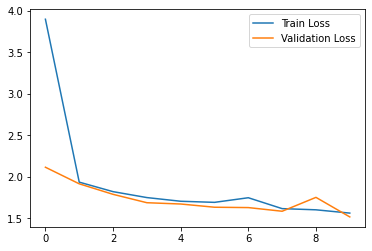

Testing VGG trained model


100%|██████████| 157/157 [00:18<00:00,  8.29it/s]


Testing loss: 1.53765386, Testing Accuracies: 0.40970000 
Testing finish!... plotting testing results


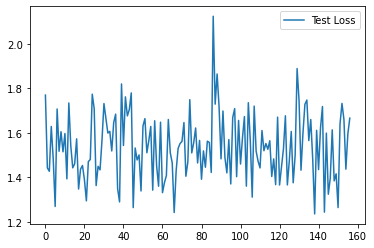

Training RESNET on cifar10 with lr=0.3 optimizer= SGD


100%|██████████| 157/157 [00:18<00:00,  8.35it/s]


Epoch 1 of 10 with 223.43 s
Training loss: 2.28993313, Validation loss: 1.65461312, Validation Accuracies: 0.39330000 


100%|██████████| 157/157 [00:18<00:00,  8.33it/s]


Epoch 2 of 10 with 223.49 s
Training loss: 1.55865576, Validation loss: 1.40458810, Validation Accuracies: 0.49530000 


100%|██████████| 157/157 [00:18<00:00,  8.33it/s]


Epoch 3 of 10 with 223.47 s
Training loss: 1.28056970, Validation loss: 1.10796009, Validation Accuracies: 0.61170000 


100%|██████████| 157/157 [00:18<00:00,  8.30it/s]


Epoch 4 of 10 with 223.69 s
Training loss: 1.06875751, Validation loss: 0.97591499, Validation Accuracies: 0.66250000 


100%|██████████| 157/157 [00:18<00:00,  8.35it/s]


Epoch 5 of 10 with 223.49 s
Training loss: 0.92718665, Validation loss: 0.92636785, Validation Accuracies: 0.67720000 


100%|██████████| 157/157 [00:18<00:00,  8.34it/s]


Epoch 6 of 10 with 223.43 s
Training loss: 0.80266568, Validation loss: 0.83354007, Validation Accuracies: 0.71490000 


100%|██████████| 157/157 [00:18<00:00,  8.31it/s]


Epoch 7 of 10 with 223.52 s
Training loss: 0.69598615, Validation loss: 0.77141484, Validation Accuracies: 0.73390000 


100%|██████████| 157/157 [00:18<00:00,  8.36it/s]


Epoch 8 of 10 with 223.42 s
Training loss: 0.60711242, Validation loss: 0.73757900, Validation Accuracies: 0.74590000 


100%|██████████| 157/157 [00:18<00:00,  8.34it/s]


Epoch 9 of 10 with 223.42 s
Training loss: 0.52498578, Validation loss: 0.75423916, Validation Accuracies: 0.75690000 


100%|██████████| 157/157 [00:18<00:00,  8.29it/s]


Epoch 10 of 10 with 223.52 s
Training loss: 0.44656472, Validation loss: 0.72933685, Validation Accuracies: 0.76570000 
Avg per epoch ptime: 223.49, total 10 epochs ptime: 2234.89
Training finish!... save and plotting training results


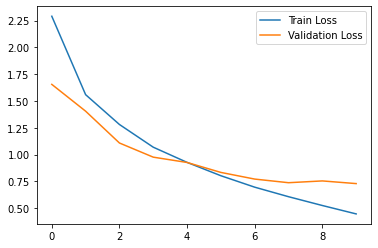

Testing VGG trained model


100%|██████████| 157/157 [00:18<00:00,  8.30it/s]


Testing loss: 0.74315251, Testing Accuracies: 0.75610000 
Testing finish!... plotting testing results


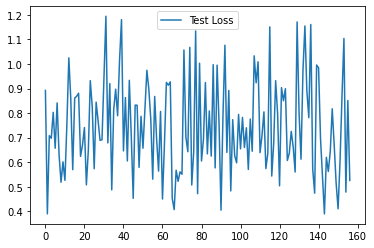

Training RESNET on cifar10 with lr=0.03 optimizer= Adam


100%|██████████| 157/157 [00:18<00:00,  8.33it/s]


Epoch 1 of 10 with 226.83 s
Training loss: 2.65808775, Validation loss: 2.07378941, Validation Accuracies: 0.20900000 


100%|██████████| 157/157 [00:18<00:00,  8.35it/s]


Epoch 2 of 10 with 226.87 s
Training loss: 1.86689160, Validation loss: 1.78672860, Validation Accuracies: 0.30580000 


100%|██████████| 157/157 [00:18<00:00,  8.36it/s]


Epoch 3 of 10 with 226.82 s
Training loss: 1.58473171, Validation loss: 1.43762549, Validation Accuracies: 0.47340000 


100%|██████████| 157/157 [00:18<00:00,  8.32it/s]


Epoch 4 of 10 with 226.85 s
Training loss: 1.34877658, Validation loss: 1.23382856, Validation Accuracies: 0.56350000 


100%|██████████| 157/157 [00:18<00:00,  8.33it/s]


Epoch 5 of 10 with 226.89 s
Training loss: 1.15548724, Validation loss: 1.11395529, Validation Accuracies: 0.60210000 


100%|██████████| 157/157 [00:18<00:00,  8.34it/s]


Epoch 6 of 10 with 226.86 s
Training loss: 1.03633775, Validation loss: 1.02005858, Validation Accuracies: 0.64140000 


100%|██████████| 157/157 [00:18<00:00,  8.32it/s]


Epoch 7 of 10 with 226.91 s
Training loss: 0.93146221, Validation loss: 0.90060419, Validation Accuracies: 0.68630000 


100%|██████████| 157/157 [00:18<00:00,  8.31it/s]


Epoch 8 of 10 with 227.03 s
Training loss: 0.84628866, Validation loss: 0.83827068, Validation Accuracies: 0.71270000 


100%|██████████| 157/157 [00:18<00:00,  8.31it/s]


Epoch 9 of 10 with 226.99 s
Training loss: 0.76132495, Validation loss: 0.84657899, Validation Accuracies: 0.70920000 


100%|██████████| 157/157 [00:18<00:00,  8.33it/s]


Epoch 10 of 10 with 226.93 s
Training loss: 0.68965579, Validation loss: 0.76320469, Validation Accuracies: 0.73840000 
Avg per epoch ptime: 226.90, total 10 epochs ptime: 2268.98
Training finish!... save and plotting training results


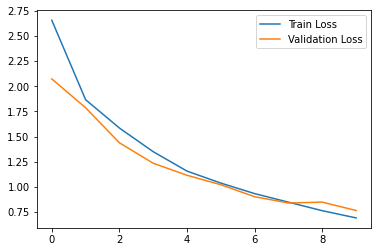

Testing VGG trained model


100%|██████████| 157/157 [00:18<00:00,  8.27it/s]


Testing loss: 0.76981749, Testing Accuracies: 0.73420000 
Testing finish!... plotting testing results


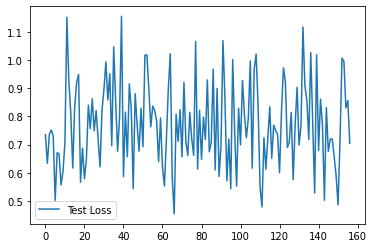

Training RESNET on cifar10 with lr=0.03 optimizer= SGD


100%|██████████| 157/157 [00:18<00:00,  8.35it/s]


Epoch 1 of 10 with 223.68 s
Training loss: 1.98061893, Validation loss: 1.59553614, Validation Accuracies: 0.42540000 


100%|██████████| 157/157 [00:18<00:00,  8.34it/s]


Epoch 2 of 10 with 223.66 s
Training loss: 1.32788174, Validation loss: 1.12062937, Validation Accuracies: 0.59990000 


100%|██████████| 157/157 [00:18<00:00,  8.28it/s]


Epoch 3 of 10 with 223.78 s
Training loss: 1.01409419, Validation loss: 0.95621395, Validation Accuracies: 0.66340000 


100%|██████████| 157/157 [00:18<00:00,  8.34it/s]


Epoch 4 of 10 with 223.71 s
Training loss: 0.80439533, Validation loss: 0.80445106, Validation Accuracies: 0.72440000 


100%|██████████| 157/157 [00:18<00:00,  8.31it/s]


Epoch 5 of 10 with 223.70 s
Training loss: 0.64283321, Validation loss: 0.78047378, Validation Accuracies: 0.73840000 


100%|██████████| 157/157 [00:18<00:00,  8.32it/s]


Epoch 6 of 10 with 223.64 s
Training loss: 0.50328669, Validation loss: 0.71312218, Validation Accuracies: 0.76620000 


100%|██████████| 157/157 [00:18<00:00,  8.30it/s]


Epoch 7 of 10 with 223.85 s
Training loss: 0.38833667, Validation loss: 0.75048929, Validation Accuracies: 0.76200000 


100%|██████████| 157/157 [00:18<00:00,  8.33it/s]


Epoch 8 of 10 with 223.64 s
Training loss: 0.28719996, Validation loss: 0.82376583, Validation Accuracies: 0.75440000 


100%|██████████| 157/157 [00:18<00:00,  8.33it/s]


Epoch 9 of 10 with 223.72 s
Training loss: 0.21624656, Validation loss: 0.82135199, Validation Accuracies: 0.77000000 


100%|██████████| 157/157 [00:18<00:00,  8.31it/s]


Epoch 10 of 10 with 223.69 s
Training loss: 0.15683997, Validation loss: 0.91462475, Validation Accuracies: 0.76340000 
Avg per epoch ptime: 223.71, total 10 epochs ptime: 2237.08
Training finish!... save and plotting training results


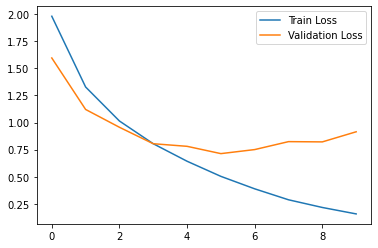

Testing VGG trained model


100%|██████████| 157/157 [00:18<00:00,  8.30it/s]


Testing loss: 0.92408505, Testing Accuracies: 0.76490000 
Testing finish!... plotting testing results


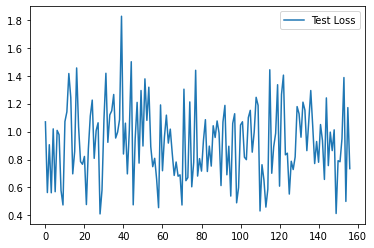

Training RESNET on cifar10 with lr=0.003 optimizer= Adam


100%|██████████| 157/157 [00:18<00:00,  8.30it/s]


Epoch 1 of 10 with 227.01 s
Training loss: 1.97946411, Validation loss: 1.54014158, Validation Accuracies: 0.43440000 


100%|██████████| 157/157 [00:18<00:00,  8.33it/s]


Epoch 2 of 10 with 226.91 s
Training loss: 1.34387138, Validation loss: 1.22398189, Validation Accuracies: 0.55700000 


100%|██████████| 157/157 [00:18<00:00,  8.30it/s]


Epoch 3 of 10 with 227.11 s
Training loss: 1.12374318, Validation loss: 0.99615498, Validation Accuracies: 0.64790000 


100%|██████████| 157/157 [00:18<00:00,  8.31it/s]


Epoch 4 of 10 with 226.98 s
Training loss: 0.96522794, Validation loss: 0.87964150, Validation Accuracies: 0.68940000 


100%|██████████| 157/157 [00:18<00:00,  8.30it/s]


Epoch 5 of 10 with 226.98 s
Training loss: 0.82146048, Validation loss: 0.80711989, Validation Accuracies: 0.71970000 


100%|██████████| 157/157 [00:18<00:00,  8.31it/s]


Epoch 6 of 10 with 227.07 s
Training loss: 0.71613841, Validation loss: 0.76062275, Validation Accuracies: 0.73960000 


100%|██████████| 157/157 [00:18<00:00,  8.30it/s]


Epoch 7 of 10 with 227.04 s
Training loss: 0.62265772, Validation loss: 0.68397920, Validation Accuracies: 0.76670000 


100%|██████████| 157/157 [00:18<00:00,  8.32it/s]


Epoch 8 of 10 with 226.93 s
Training loss: 0.54447302, Validation loss: 0.69108392, Validation Accuracies: 0.76470000 


100%|██████████| 157/157 [00:18<00:00,  8.33it/s]


Epoch 9 of 10 with 227.05 s
Training loss: 0.46517546, Validation loss: 0.66436238, Validation Accuracies: 0.77510000 


100%|██████████| 157/157 [00:18<00:00,  8.29it/s]


Epoch 10 of 10 with 227.07 s
Training loss: 0.40090777, Validation loss: 0.62973175, Validation Accuracies: 0.79630000 
Avg per epoch ptime: 227.02, total 10 epochs ptime: 2270.17
Training finish!... save and plotting training results


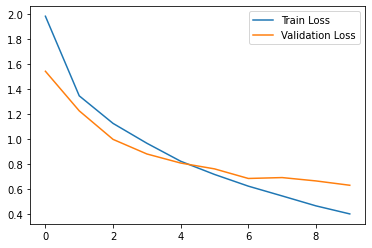

Testing VGG trained model


100%|██████████| 157/157 [00:18<00:00,  8.27it/s]


Testing loss: 0.63577948, Testing Accuracies: 0.79410000 
Testing finish!... plotting testing results


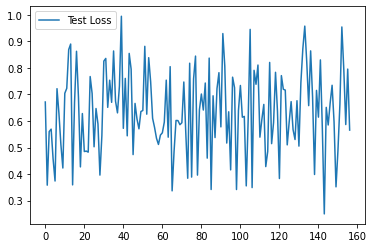

Training RESNET on cifar10 with lr=0.003 optimizer= SGD


100%|██████████| 157/157 [00:18<00:00,  8.32it/s]


Epoch 1 of 10 with 223.70 s
Training loss: 2.07536371, Validation loss: 1.80677099, Validation Accuracies: 0.32580000 


100%|██████████| 157/157 [00:18<00:00,  8.30it/s]


Epoch 2 of 10 with 223.83 s
Training loss: 1.69628698, Validation loss: 1.60304992, Validation Accuracies: 0.40560000 


100%|██████████| 157/157 [00:18<00:00,  8.30it/s]


Epoch 3 of 10 with 223.75 s
Training loss: 1.50246923, Validation loss: 1.44610430, Validation Accuracies: 0.48230000 


100%|██████████| 157/157 [00:18<00:00,  8.30it/s]


Epoch 4 of 10 with 223.86 s
Training loss: 1.33642099, Validation loss: 1.26847534, Validation Accuracies: 0.54950000 


100%|██████████| 157/157 [00:18<00:00,  8.32it/s]


Epoch 5 of 10 with 223.72 s
Training loss: 1.20098165, Validation loss: 1.20069540, Validation Accuracies: 0.57580000 


100%|██████████| 157/157 [00:18<00:00,  8.33it/s]


Epoch 6 of 10 with 223.71 s
Training loss: 1.07040009, Validation loss: 1.10898836, Validation Accuracies: 0.61360000 


100%|██████████| 157/157 [00:18<00:00,  8.30it/s]


Epoch 7 of 10 with 223.81 s
Training loss: 0.95089863, Validation loss: 1.05321583, Validation Accuracies: 0.63410000 


100%|██████████| 157/157 [00:18<00:00,  8.33it/s]


Epoch 8 of 10 with 223.75 s
Training loss: 0.84483191, Validation loss: 0.98485306, Validation Accuracies: 0.65770000 


100%|██████████| 157/157 [00:18<00:00,  8.33it/s]


Epoch 9 of 10 with 223.71 s
Training loss: 0.73602117, Validation loss: 1.00764604, Validation Accuracies: 0.65740000 


100%|██████████| 157/157 [00:18<00:00,  8.28it/s]


Epoch 10 of 10 with 223.85 s
Training loss: 0.62985284, Validation loss: 0.99494143, Validation Accuracies: 0.66830000 
Avg per epoch ptime: 223.77, total 10 epochs ptime: 2237.70
Training finish!... save and plotting training results


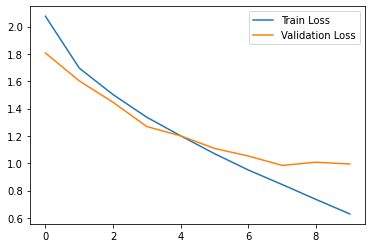

Testing VGG trained model


100%|██████████| 157/157 [00:18<00:00,  8.30it/s]


Testing loss: 1.00402374, Testing Accuracies: 0.66560000 
Testing finish!... plotting testing results


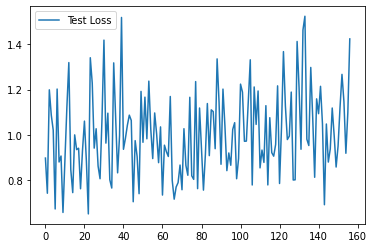

Training RESNET on cifar10 with lr=0.0003 optimizer= Adam


100%|██████████| 157/157 [00:18<00:00,  8.33it/s]


Epoch 1 of 10 with 226.96 s
Training loss: 1.50699420, Validation loss: 1.17276076, Validation Accuracies: 0.58640000 


100%|██████████| 157/157 [00:18<00:00,  8.33it/s]


Epoch 2 of 10 with 226.98 s
Training loss: 0.99611119, Validation loss: 0.94311223, Validation Accuracies: 0.66540000 


100%|██████████| 157/157 [00:18<00:00,  8.34it/s]


Epoch 3 of 10 with 226.92 s
Training loss: 0.77412811, Validation loss: 0.74442938, Validation Accuracies: 0.74310000 


100%|██████████| 157/157 [00:18<00:00,  8.30it/s]


Epoch 4 of 10 with 227.03 s
Training loss: 0.64567335, Validation loss: 0.68489070, Validation Accuracies: 0.76600000 


100%|██████████| 157/157 [00:18<00:00,  8.33it/s]


Epoch 5 of 10 with 226.98 s
Training loss: 0.54377910, Validation loss: 0.65441511, Validation Accuracies: 0.77760000 


100%|██████████| 157/157 [00:18<00:00,  8.31it/s]


Epoch 6 of 10 with 227.08 s
Training loss: 0.45280876, Validation loss: 0.59206761, Validation Accuracies: 0.80910000 


100%|██████████| 157/157 [00:18<00:00,  8.29it/s]


Epoch 7 of 10 with 227.12 s
Training loss: 0.38377977, Validation loss: 0.59322046, Validation Accuracies: 0.80400000 


100%|██████████| 157/157 [00:18<00:00,  8.32it/s]


Epoch 8 of 10 with 226.97 s
Training loss: 0.30906093, Validation loss: 0.59041777, Validation Accuracies: 0.80880000 


100%|██████████| 157/157 [00:18<00:00,  8.31it/s]


Epoch 9 of 10 with 227.02 s
Training loss: 0.24504612, Validation loss: 0.64940132, Validation Accuracies: 0.80680000 


100%|██████████| 157/157 [00:18<00:00,  8.31it/s]


Epoch 10 of 10 with 227.00 s
Training loss: 0.19501338, Validation loss: 0.72359012, Validation Accuracies: 0.79710000 
Avg per epoch ptime: 227.00, total 10 epochs ptime: 2270.06
Training finish!... save and plotting training results


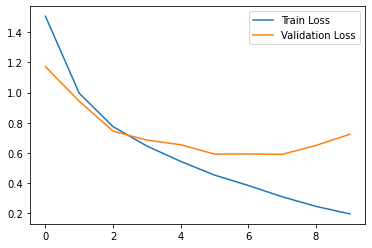

Testing VGG trained model


100%|██████████| 157/157 [00:18<00:00,  8.27it/s]


Testing loss: 0.70898259, Testing Accuracies: 0.80210000 
Testing finish!... plotting testing results


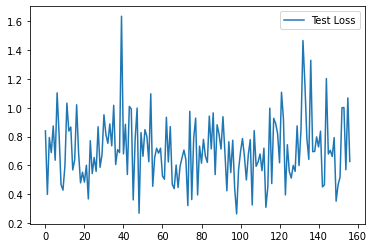

Training RESNET on cifar10 with lr=0.0003 optimizer= SGD


100%|██████████| 157/157 [00:18<00:00,  8.32it/s]


Epoch 1 of 10 with 223.78 s
Training loss: 2.25225497, Validation loss: 2.22407046, Validation Accuracies: 0.17440000 


100%|██████████| 157/157 [00:18<00:00,  8.29it/s]


Epoch 2 of 10 with 223.81 s
Training loss: 2.20884478, Validation loss: 2.18610632, Validation Accuracies: 0.19420000 


100%|██████████| 157/157 [00:18<00:00,  8.33it/s]


Epoch 3 of 10 with 223.69 s
Training loss: 2.16064944, Validation loss: 2.14047568, Validation Accuracies: 0.21790000 


100%|██████████| 157/157 [00:19<00:00,  8.25it/s]


Epoch 4 of 10 with 223.89 s
Training loss: 2.11566243, Validation loss: 2.09594518, Validation Accuracies: 0.23550000 


100%|██████████| 157/157 [00:18<00:00,  8.27it/s]


Epoch 5 of 10 with 223.81 s
Training loss: 2.07018492, Validation loss: 2.05452060, Validation Accuracies: 0.24850000 


100%|██████████| 157/157 [00:18<00:00,  8.29it/s]


Epoch 6 of 10 with 223.74 s
Training loss: 2.01822605, Validation loss: 1.99848637, Validation Accuracies: 0.26840000 


100%|██████████| 157/157 [00:18<00:00,  8.29it/s]


Epoch 7 of 10 with 223.80 s
Training loss: 1.96442136, Validation loss: 1.93434836, Validation Accuracies: 0.28380000 


100%|██████████| 157/157 [00:18<00:00,  8.33it/s]


Epoch 8 of 10 with 223.75 s
Training loss: 1.88702245, Validation loss: 1.85115124, Validation Accuracies: 0.32560000 


100%|██████████| 157/157 [00:18<00:00,  8.30it/s]


Epoch 9 of 10 with 223.77 s
Training loss: 1.81537102, Validation loss: 1.78270897, Validation Accuracies: 0.34820000 


100%|██████████| 157/157 [00:18<00:00,  8.32it/s]


Epoch 10 of 10 with 223.76 s
Training loss: 1.75445215, Validation loss: 1.73400387, Validation Accuracies: 0.36370000 
Avg per epoch ptime: 223.78, total 10 epochs ptime: 2237.83
Training finish!... save and plotting training results


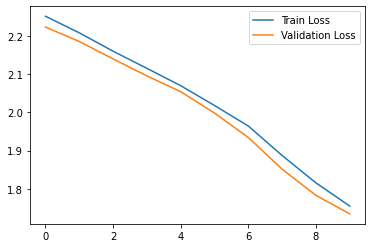

Testing VGG trained model


100%|██████████| 157/157 [00:19<00:00,  8.25it/s]


Testing loss: 1.73494043, Testing Accuracies: 0.36260000 
Testing finish!... plotting testing results


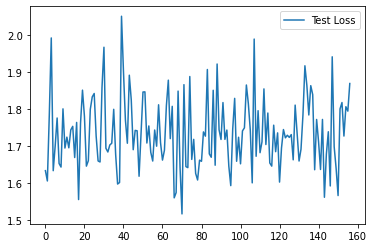

In [17]:
logger.info("Trianing RESNET on CIFAR dataset") 

for lr in [0.3, 0.03, 0.003, 0.0003]:
    for optimizer in ['Adam', 'SGD']:
        print("========================================================")
        #Cross Entropy Loss function
        criterion = nn.CrossEntropyLoss()

        if os.path.isfile(mnist_save_dir+"/resnet_cifar_lr-{}_opt-{}_".format(lr,optimizer)+".pt"):
            print("Already trained RESNET on cifar with lr={} optimizer= {}".format(lr,optimizer))
  

        else:
            model = ResNet50(num_channels = 3, num_classes = 10)
            #model.eval()

            if optimizer == 'Adam':
                model_optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            if optimizer == 'SGD':
                model_optimizer = torch.optim.SGD(model.parameters(), lr=lr)

          
            print("Training RESNET on cifar10 with lr={} optimizer= {}".format(lr,optimizer))
          
            model_log_path = 'content/drive/MyDrive/DLCV_CW3/run_logs/cifar_resnet_train_lr-{}_opt-{}_'.format(lr,optimizer) +datetime.today().strftime("%d-%m-%Y-%H-%M-%S")

            trained_model, train_hist = train_model(model, model_log_path, cifar_train_loader, cifar_val_loader, criterion, model_optimizer)
            
            print("Training finish!... save and plotting training results")

            with open(cifar_save_dir +'resnet_train_hist_lr-{}_opt-{}_'.format(lr,optimizer)+datetime.today().strftime("%d-%m-%Y-%H-%M-%S")+'.pkl', 'wb') as f:
                pickle.dump(train_hist, f)

            logger.info("Saving RESNET trained model on CIFAR dataset") 
            torch.save(model.state_dict(), cifar_save_dir+"/resnet_cifar_lr-{}_opt-{}_".format(lr,optimizer)+".pt") 

            logger.info("Plotting RESNET Model train losses on CIFAR") 

            plt.plot(train_hist['model_train_losses'])
            plt.plot(train_hist['model_val_losses'])
            plt.legend(["Train Loss", "Validation Loss"])
            plt.savefig(cifar_fig_dir + "/resnet_train_val_loss_lr-{}_opt-{}_".format(lr,optimizer)+".png") 
            plt.show()

            print("Testing VGG trained model")
            test_loss = test_model(model, cifar_test_loader, criterion)
            print("Testing finish!... plotting testing results")
            plt.plot(test_loss)
            plt.legend(["Test Loss"])
            plt.savefig(cifar_fig_dir + "/resnet_test_val_loss_lr-{}_opt-{}_".format(lr,optimizer)+".png") 
            plt.show()
        print("========================================================")
